In [1]:
import sys
sys.path.append('../')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import networkit as nk
from tqdm import tqdm
import networkx as nx

from benji_girgs import generation, utils, plotting
import geopandas as gpd


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import glob
glob.glob('./flight*')

['./flights.ipynb', './flights2.ipynb', './flightlist_20190601_20190630.csv']

In [4]:
fn = './flightlist_20190601_20190630.csv'
df = pd.read_csv(fn)

In [5]:
df = df.loc[:, ['aircraft_uid', 'origin', 'destination', 'day']]
df.shape
df = df.dropna()

(2660901, 4)

In [6]:
airports = list(np.union1d(df.origin.unique(), df.destination.unique()))

In [7]:
adf = pd.read_csv('./airport-codes_csv.csv')

In [8]:
missing_airports = set([a for a in airports if not a in adf.ident.values])
present_airports = [a for a in airports if a in adf.ident.values]
airports = present_airports
a, b = df.origin.apply(lambda x: x in missing_airports), df.destination.apply(lambda x: x in missing_airports)

df = df[~(a|b)]
df['airport_pair'] = df.apply(lambda x: set([x.origin, x.destination]), axis=1)
df = df[df['airport_pair'].apply(len) == 2]
df['airport_pair'] = df.airport_pair.apply(frozenset)

In [9]:

g = nk.Graph(len(airports), weighted=True)
print(g.isWeighted())
pair_counts = df.groupby(['airport_pair']).aircraft_uid.count()
thresh = 1
for pair, count in tqdm(pair_counts.items()):
    u, v = tuple(pair)
    u_id, v_id = airports.index(u), airports.index(v)
    _ = g.addEdge(u_id, v_id, w=count)
    

    
weight_thresh = 1
gthresh = nk.Graph(len(airports))
for u, v, weight in tqdm(g.iterEdgesWeights()):
    if weight >= weight_thresh:
        _ = gthresh.addEdge(u, v)

True


130704it [00:10, 12335.51it/s]
130704it [00:00, 3256674.55it/s]


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
powerlaw alpha: 2.103


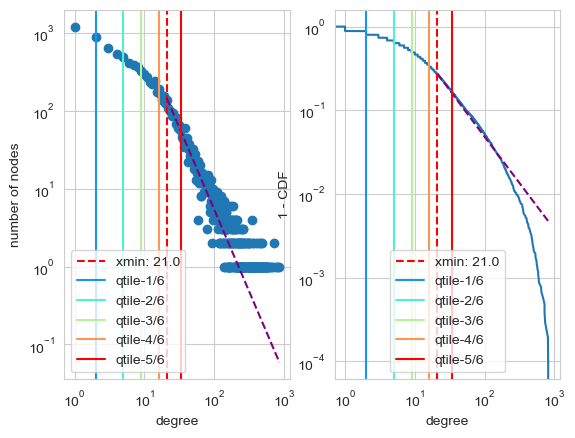

In [10]:
plotting.plot_degree_dist(gthresh, vlines=6, pl_fit=True)

In [11]:
adf_mini = adf.set_index('ident')
adf_mini = adf_mini.loc[airports]

# reversed s.t. latitude then longitude
adf_mini['coordinates'] = adf_mini.coordinates.apply(lambda x: tuple(reversed([float(y) for y in x.split(', ')])))

adf_mini['lat'] = adf_mini['coordinates'].apply(lambda x: x[0])
adf_mini['long'] = adf_mini['coordinates'].apply(lambda x: x[1])


In [12]:
from geopy import distance

In [13]:
dists = pd.read_csv('airport_distances3.csv.gz')

In [14]:
dists.head()

,Unnamed: 0,ident,00AK,00AL,00AZ,00CL,00FA,00GA,00ID,00IL,...,YYNG,YYOR,YYRK,YYRM,YZCE,Z19O,ZGGG,ZGSD,ZGSZ,ZUCK
0,0,00AK,0.000000,5349.974219,4031.313953,3090.913579,6160.861618,5597.685971,2624.290470,4588.083436,...,11793.368335,12335.258127,13092.521568,12279.402422,10940.267793,9538.732344,8055.052259,8181.755727,8098.583026,7805.232639
1,1,00AL,5349.974219,0.000000,2324.456065,3129.788327,813.072495,276.870514,2840.512023,826.243658,...,15041.578634,16004.551823,17812.910704,15291.485510,14405.932770,10295.357189,13219.621421,13362.340135,13281.442748,12719.047508
2,2,00AZ,4031.313953,2324.456065,0.000000,1026.459060,2902.851009,2586.987864,1573.474113,2148.411670,...,12838.214527,13767.080535,15490.615548,13155.315096,12139.509525,11708.704794,12021.825087,12137.284974,12054.551262,11834.790477
3,3,00CL,3090.913579,3129.788327,1026.459060,0.000000,3808.023298,3405.451955,1065.973722,2720.116619,...,12322.898713,13193.702330,14745.928966,12695.771474,11560.525005,11521.142414,11011.046593,11123.670073,11041.193486,10862.957523
4,4,00FA,6160.861618,813.072495,2902.851009,3808.023298,0.000000,594.573226,3627.065931,1621.317935,...,15237.780207,16215.422832,18165.876494,15404.310732,14706.867858,10469.324110,14012.640431,14157.147004,14076.906000,13477.241248


In [15]:
dists = dists.iloc[:, 1:]
dists = dists.set_index('ident')

In [16]:
dists_np = dists.to_numpy()

In [17]:
dists_np.shape

(10317, 10317)

In [18]:
a, b = adf_mini.loc['00AK'].coordinates, adf_mini.loc['00AZ'].coordinates
a, b
distance.distance(a, b)

((59.94919968, -151.695999146), (34.305599212646484, -112.16500091552734))

Distance(4031.3139530844023)

In [19]:
dists_np[0, 2]

4031.313953084402

In [20]:
# 0.5 circumference of the earth (and dists_np.max()) is roughly 20000 km
dists_np = dists_np * np.sqrt(2)/20000

In [21]:
dists_np.max()

1.414097672012551

In [44]:
sub_indices = np.random.choice(dists_np.shape[0], 4000)
dists_np2 = dists_np[sub_indices][:, sub_indices]
gthresh2 = utils.quick_subgraph(gthresh, sub_indices)

In [179]:
import imp
import benji_src.benji_girgs
imp.reload(benji_src.benji_girgs)
imp.reload(benji_src.benji_girgs.utils)
from benji_src.benji_girgs import utils

<module 'benji_src.benji_girgs' from '/Users/benjidayan/GDrive/eth_courses/GIRG/benji_src/../benji_src/benji_girgs/__init__.py'>

<module 'benji_src.benji_girgs.utils' from '/Users/benjidayan/GDrive/eth_courses/GIRG/benji_src/../benji_src/benji_girgs/utils.py'>

In [46]:
gthresh2.numberOfNodes()

4000

In [53]:
delta = 0.001
degrees = np.array([gthresh2.degree(i) for i in range(gthresh2.numberOfNodes())]).astype(np.float64)
degrees[degrees == 0] += delta
weights = degrees / len(degrees)

In [180]:
asdf = utils.AirportLikelihoodGirgFitter(weights, dists_np2, gthresh2)
asdf.num_edges=3000
asdf.alpha=1.5
asdf.const=1
self = asdf


/Users/benjidayan/GDrive/eth_courses/GIRG/benji_src/../benji_src/benji_girgs/utils.py:312: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.A_true = nx.adjacency_matrix(nk.nxadapter.nk2nx(g_true)).toarray()


percs_true_median: 0.3333333333333333, avg_degree_true: 6.305


/Users/benjidayan/GDrive/eth_courses/GIRG/benji_src/../benji_src/benji_girgs/utils.py:324: RuntimeWarning: divide by zero encountered in divide
  self.p_uv_initial = np.nan_to_num(outer / self.dists**self.d)


In [181]:
asdf.alpha=1.5
g_girg = self.gen_new_girg()
# do some decisions
log_likelihood, gradient_c, gradient_alpha = self.log_likelihood()
print(f'log_likelihood: {log_likelihood:.4e}, gradient_c: {gradient_c:.4e}, gradient_alpha: {gradient_alpha:.4e}')
        

log_likelihood: -1.9689e+05, gradient_c: -4.8420e+10, gradient_alpha: -6.5434e+04


In [182]:
A = self.A_true
A_bar = -self.A_true + 1
np.fill_diagonal(A, 0)
np.fill_diagonal(A_bar, 0)

# this is all very painful, maybe we can just clip p_uv not to be 0 or 1
eps = 1e-7
p_uv = np.clip(self.p_uv, eps, 1-eps)

# self.p_uv has some 0s and 1s, so np.log gives some -inf. We
# do nan_to_num which makes -inf -> large negative number, s.t.
# A_ij * ?_ij is 0 and not nan when previously ?_ij was -inf.

# of course if A_ij is not 0, i.e. we have an edge, yet still
# self.p_uv is 0, we -ve large, and log_likelihood will be
# -inf probably. :(
log_likelihood = np.sum(
    A * np.nan_to_num((np.log(p_uv))) + 
    A_bar * np.nan_to_num((np.log(1 -p_uv)))
    )

p_uv_less_than_one = self.p_uv < 1
dp_uv_dc = self.p_uv_pow_alpha * p_uv_less_than_one
dp_uv_dalpha = p_uv_less_than_one * p_uv * np.log(self.p_uv_initial)

# gradient_c = np.sum(np.nan_to_num(A / p_uv) * dp_uv_dc + np.nan_to_num(A_bar / (1 - p_uv)) * (- dp_uv_dc))
gradient_c = np.sum(
    A / self.const + 
    A_bar / (1 - p_uv) * (-p_uv / self.const)
)
gradient_alpha = np.sum(
    A / p_uv * dp_uv_dalpha +
    A_bar / (1 - p_uv) * (- dp_uv_dalpha)
)


In [183]:
gradient_alpha

-65434.440620426816

In [178]:
dp_uv_dalpha

array([[           -inf, -1.95310116e-06, -1.85136858e-06, ...,
        -1.99928399e-06, -1.53529859e-06, -1.73067991e-06],
       [-1.95310116e-06,            -inf, -1.65104984e-02, ...,
        -1.31649348e-06, -1.07183942e-06, -1.11140781e-06],
       [-1.85136858e-06, -1.65104984e-02,            -inf, ...,
        -1.21204871e-06, -3.87510370e-06, -2.25036721e-06],
       ...,
       [-1.99928399e-06, -1.31649348e-06, -1.21204871e-06, ...,
                   -inf, -1.49726674e-06, -8.97765572e-06],
       [-1.53529859e-06, -1.07183942e-06, -3.87510370e-06, ...,
        -1.49726674e-06,            -inf, -1.10422509e-04],
       [-1.73067991e-06, -1.11140781e-06, -2.25036721e-06, ...,
        -8.97765572e-06, -1.10422509e-04,            -inf]])

In [144]:
temp  = self.const * self.alpha * np.power(self.p_uv_initial, self.alpha - 1) * p_uv_less_than_one
np.sum(A / p_uv * temp)
np.sum(A_bar / (1 - p_uv) * (-temp))

np.sum(A / p_uv * dp_uv_dalpha)
np.sum(A_bar / (1 - p_uv) * (-dp_uv_dalpha))


14180476.947777981

-198160.03518978835

14180476.947777981

-198160.03518978835

In [148]:
c1, r1, a1 = 1, .01, 1.5
c1 * r1**a1
c1 * r1**(a1+.1)
c1 * r1**(a1-.1)
c1 * r1**(a1 - 1) * a1

0.001

0.000630957344480193

0.001584893192461114

0.15000000000000002

In [110]:
dp_uv_dalpha

array([[0.00000000e+00, 1.07023114e-15, 7.25410887e-15, ...,
        4.48937614e-16, 2.77156228e-12, 7.02348734e-14],
       [1.07023114e-15, 0.00000000e+00, 1.26443704e-02, ...,
        1.69925148e-10, 1.69419858e-08, 8.04839823e-09],
       [7.25410887e-15, 1.26443704e-02, 0.00000000e+00, ...,
        1.21205256e-09, 1.16747928e-07, 5.67954881e-08],
       ...,
       [4.48937614e-16, 1.69925148e-10, 1.21205256e-09, ...,
        0.00000000e+00, 3.31322297e-08, 3.57129893e-07],
       [2.77156228e-12, 1.69419858e-08, 1.16747928e-07, ...,
        3.31322297e-08, 0.00000000e+00, 1.04668203e-05],
       [7.02348734e-14, 8.04839823e-09, 5.67954881e-08, ...,
        3.57129893e-07, 1.04668203e-05, 0.00000000e+00]])

In [169]:
np.log(1e-7)

-16.11809565095832

In [80]:
np.sum(A / self.const)
np.sum(A / self.const * p_uv_less_than_one)
np.sum(A_bar / (1 - p_uv) * (-p_uv / self.const))
np.sum(A_bar / (1 - p_uv) * (-p_uv / self.const) * p_uv_less_than_one)

181414.42456508943

170034.66169189458

-181414437897.3906

-31378.25460160691

In [236]:
asdf = utils.AirportLikelihoodGirgFitter(weights, dists_np2, gthresh2)
asdf.num_edges=3000
asdf.alpha=1.5
asdf.const=1
self = asdf

# self.alpha_step_size=1e-7

# asdf.step_n(5)

/Users/benjidayan/GDrive/eth_courses/GIRG/benji_src/../benji_src/benji_girgs/utils.py:312: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.A_true = nx.adjacency_matrix(nk.nxadapter.nk2nx(g_true)).toarray()


percs_true_median: 0.3333333333333333, avg_degree_true: 6.305


ValueError: operands could not be broadcast together with shapes (10317,10317) (4000,4000) 

In [185]:
asdf.step_n(5)

log_likelihood: -1.9689e+05, gradient_c: -4.8420e+10, gradient_alpha: -6.5434e+04
g_girg avg deg: 3.89, g_true avg deg 6.30
alpha: - c: - 
alpha: 1.350, const: 7.0000e-01
log_likelihood: -1.2067e+05, gradient_c: 1.0618e+04, gradient_alpha: -6.5958e+04
g_girg avg deg: 3.06, g_true avg deg 6.30
alpha: - c: + 
alpha: 1.255, const: 9.6081e-01
log_likelihood: -1.1966e+05, gradient_c: -1.1335e+05, gradient_alpha: -5.8086e+04
g_girg avg deg: 4.45, g_true avg deg 6.30
alpha: - c: - 
alpha: 1.192, const: 7.2482e-01
log_likelihood: -1.1049e+05, gradient_c: 4.9866e+03, gradient_alpha: -6.0104e+04
g_girg avg deg: 3.56, g_true avg deg 6.30
alpha: - c: + 
alpha: 1.150, const: 9.3194e-01
log_likelihood: -1.1145e+05, gradient_c: -6.1292e+04, gradient_alpha: -5.2216e+04
g_girg avg deg: 4.84, g_true avg deg 6.30
alpha: - c: - 
alpha: 1.120, const: 7.4453e-01


In [186]:
asdf.step_n(7)

log_likelihood: -1.0622e+05, gradient_c: 6.7701e+02, gradient_alpha: -5.5360e+04
g_girg avg deg: 4.00, g_true avg deg 6.30
alpha: - c: + 
alpha: 1.098, const: 9.1014e-01
log_likelihood: -1.0770e+05, gradient_c: -4.4208e+04, gradient_alpha: -4.8405e+04
g_girg avg deg: 4.98, g_true avg deg 6.30
alpha: - c: - 
alpha: 1.082, const: 7.6029e-01
log_likelihood: -1.0420e+05, gradient_c: -2.6186e+03, gradient_alpha: -5.1932e+04
g_girg avg deg: 4.26, g_true avg deg 6.30
alpha: - c: - 
alpha: 1.070, const: 6.4702e-01
log_likelihood: -1.0403e+05, gradient_c: 1.0438e+04, gradient_alpha: -5.4662e+04
g_girg avg deg: 3.67, g_true avg deg 6.30
alpha: - c: + 
alpha: 1.060, const: 7.4783e-01
log_likelihood: -1.0307e+05, gradient_c: -1.6494e+03, gradient_alpha: -5.0411e+04
g_girg avg deg: 4.36, g_true avg deg 6.30
alpha: - c: - 
alpha: 1.053, const: 6.5662e-01
log_likelihood: -1.0304e+05, gradient_c: 8.8314e+03, gradient_alpha: -5.2976e+04
g_girg avg deg: 3.88, g_true avg deg 6.30
alpha: - c: + 
alpha: 1.

In [154]:
asdf.scalers
asdf.temp_scalers

array([0.3, 0.3])

array([0.1, 0.1])

In [164]:
self.alpha=0.95
self.step()

log_likelihood: -9.8149e+04, gradient_c: -4.9123e+03, gradient_alpha: nan
g_girg avg deg: 5.11, g_true avg deg 6.30
alpha: - c: - 
alpha: 0.951, const: 7.1894e-01


In [165]:
self.alpha=0.90
self.step()

log_likelihood: -9.6421e+04, gradient_c: -5.9447e+03, gradient_alpha: nan
g_girg avg deg: 5.54, g_true avg deg 6.30
alpha: - c: - 
alpha: 0.902, const: 7.0444e-01


In [166]:
self.alpha=0.85
self.step()

log_likelihood: -9.5186e+04, gradient_c: -8.0833e+03, gradient_alpha: nan
g_girg avg deg: 6.02, g_true avg deg 6.30
alpha: - c: - 
alpha: 0.853, const: 6.9159e-01


In [167]:
self.alpha=0.7
self.step()

log_likelihood: -9.7088e+04, gradient_c: -2.6760e+04, gradient_alpha: nan
g_girg avg deg: 9.20, g_true avg deg 6.30
alpha: - c: - 
alpha: 0.705, const: 6.8018e-01


In [160]:
A = self.A_true
A_bar = -self.A_true + 1
np.sum(self.A_true * self.p_uv) + np.sum(A_bar * np.nan_to_num((np.log(1 -p_uv))))

-80353.6294175103

In [229]:
np.sum(np.nan_to_num(A / p_uv) * dp_uv_dc)
np.sum(np.nan_to_num(A_bar / (1 - p_uv)) * (- dp_uv_dc))

264748528791364.88

-3614178860734198.0

In [247]:
foo = np.argwhere((A != 0) & (p_uv < 5e-7))
idx = tuple(foo.T)

In [248]:
dp_uv_dc[idx] * A[idx] / p_uv[idx]

array([1.79831904e+10, 1.79831904e+10, 1.79831904e+10, 1.79831904e+10,
       1.79831904e+10, 1.79831904e+10, 1.79831904e+10, 1.79831904e+10,
       1.79831904e+10, 1.79831904e+10, 1.79831904e+10, 1.79831904e+10,
       1.79831904e+10, 1.79831904e+10])

In [249]:
p_uv[idx]

array([1.67856805e-07, 3.49948937e-07, 3.50065528e-07, 1.67856805e-07,
       3.45561647e-07, 4.94046617e-07, 3.45561647e-07, 3.74406207e-07,
       3.74406207e-07, 1.39975177e-07, 3.50065528e-07, 3.49948937e-07,
       1.39975177e-07, 4.94046617e-07])

In [251]:
dp_uv_dc[idx]

array([3018.60087838, 6293.19836139, 6295.29504235, 3018.60087838,
       6214.30088328, 8884.53436241, 6214.30088328, 6733.01809638,
       6733.01809638, 2517.20025749, 6295.29504235, 6293.19836139,
       2517.20025749, 8884.53436241])

In [259]:
1/asdf.const

17983190381.15482

In [256]:
(1.5e-7)**(asdf.alpha - 1)

2.2823093092147247e-05

In [255]:
(3e-7)**1.5

1.6431676725154982e-10

In [211]:
g_girg = self.gen_new_girg()
# do some decisions
log_likelihood, gradient_c, gradient_alpha = self.log_likelihood()
print(f'log_likelihood: {log_likelihood:.4e}, gradient_c: {gradient_c:.4e}, gradient_alpha: {gradient_alpha:.4e}')
        

log_likelihood: -6.3905e+05, gradient_c: -2.0850e+14, gradient_alpha: -1.9506e-04


In [214]:
print(f'{avg_degree(g_girg):.2f}')

21.13


In [212]:
nk.overview(g_girg)

Network Properties:
nodes, edges			4000, 42262
directed?			False
weighted?			False
isolated nodes			1402
self-loops			0
density				0.005284
clustering coefficient		0.393532
min/max/avg degree		0, 475, 21.131000
degree assortativity		-0.052772
number of connected components	1435
size of largest component	2468 (61.70 %)


In [187]:
asdf.alpha = 1.00001

g_girg = self.gen_new_girg()
# do some decisions
log_likelihood, gradient_c, gradient_alpha = self.log_likelihood()
print(f'log_likelihood: {log_likelihood:.4e}, gradient_c: {gradient_c:.4e}, gradient_alpha: {gradient_alpha:.4e}')
        

log_likelihood: -1.3471e+05, gradient_c: 1.6186e+10, gradient_alpha: -5.2978e-02


In [188]:
asdf.alpha = 1.01


g_girg = self.gen_new_girg()
# do some decisions
log_likelihood, gradient_c, gradient_alpha = self.log_likelihood()
print(f'log_likelihood: {log_likelihood:.4e}, gradient_c: {gradient_c:.4e}, gradient_alpha: {gradient_alpha:.4e}')
        

log_likelihood: -1.3493e+05, gradient_c: -1.8044e+11, gradient_alpha: -4.9491e-02


In [189]:
asdf.alpha = 1.05

g_girg = self.gen_new_girg()
# do some decisions
log_likelihood, gradient_c, gradient_alpha = self.log_likelihood()
print(f'log_likelihood: {log_likelihood:.4e}, gradient_c: {gradient_c:.4e}, gradient_alpha: {gradient_alpha:.4e}')


log_likelihood: -1.3997e+05, gradient_c: -5.6675e+11, gradient_alpha: -3.8908e-02


In [197]:

A = self.A_true
A_bar = -self.A_true + 1

# this is all very painful, maybe we can just clip p_uv not to be 0 or 1
eps = 1e-5
p_uv = np.clip(self.p_uv, eps, 1-eps)

# self.p_uv has some 0s and 1s, so np.log gives some -inf. We
# do nan_to_num which makes -inf -> large negative number, s.t.
# A_ij * ?_ij is 0 and not nan when previously ?_ij was -inf.

# of course if A_ij is not 0, i.e. we have an edge, yet still
# self.p_uv is 0, we -ve large, and log_likelihood will be
# -inf probably. :(
log_likelihood = np.sum(
    A * np.nan_to_num((np.log(p_uv))) + 
    A_bar * np.nan_to_num((np.log(1 -p_uv)))
    )

p_uv_less_than_one = self.p_uv < 1
dp_uv_dc = self.p_uv_pow_alpha * p_uv_less_than_one
dp_uv_dalpha = self.const * np.power(self.p_uv, self.alpha - 1) * self.alpha * p_uv_less_than_one

gradient_c = np.sum(np.nan_to_num(A / p_uv) * dp_uv_dc + np.nan_to_num(A_bar / (1 - p_uv)) * (- dp_uv_dc))
gradient_alpha = np.sum(np.nan_to_num(A / p_uv) * dp_uv_dalpha + np.nan_to_num(A_bar / (1 - p_uv)) * (- dp_uv_dalpha))


In [198]:
np.sum(np.nan_to_num(A / p_uv) * dp_uv_dalpha)
np.sum(np.nan_to_num(A_bar / (1 - p_uv)) * (- dp_uv_dalpha))

0.25933008243116457

-0.11803337276726887

In [199]:
log_likelihood

-145199.4626978061

In [191]:
log_likelihood

-139967.7777605172

In [181]:
nk.overview(g_girg)

Network Properties:
nodes, edges			4000, 7352
directed?			False
weighted?			False
isolated nodes			1922
self-loops			0
density				0.000919
clustering coefficient		0.145136
min/max/avg degree		0, 99, 3.676000
degree assortativity		-0.003318
number of connected components	1960
size of largest component	1974 (49.35 %)


In [177]:
nk.overview(asdf.g_true)

Network Properties:
nodes, edges			4000, 13494
directed?			False
weighted?			False
isolated nodes			1231
self-loops			0
density				0.001687
clustering coefficient		0.216992
min/max/avg degree		0, 266, 6.747000
degree assortativity		-0.031688
number of connected components	1244
size of largest component	2730 (68.25 %)


In [159]:
eps = 1e-3
p_uv = np.clip(self.p_uv, eps, 1 - eps)

A = self.A_true
A_bar = -self.A_true + 1

# self.p_uv has some 0s and 1s, so np.log gives some -inf. We
# do nan_to_num which makes -inf -> large negative number, s.t.
# A_ij * ?_ij is 0 and not nan when previously ?_ij was -inf.
log_likelihood = np.sum(
    A * np.nan_to_num((np.log(p_uv))) + 
    A_bar * np.nan_to_num((np.log(1 - p_uv)))
    )

p_uv_less_than_one = self.p_uv < 1
dp_uv_dc = self.p_uv_pow_alpha * p_uv_less_than_one
dp_uv_dalpha = self.const * np.power(self.p_uv, self.alpha - 1) * self.alpha * p_uv_less_than_one

gradient_c = np.sum((A / p_uv) * dp_uv_dc + (A_bar / (1 - p_uv)) * (- dp_uv_dc))
gradient_alpha = np.sum((A / p_uv) * dp_uv_dalpha + (A_bar / (1 - p_uv)) * (- dp_uv_dalpha))


In [160]:
log_likelihood

-1080153.3532322454

In [126]:
stuff = np.argwhere(A)

In [127]:
stuff = np.argwhere(A)
a = np.nan_to_num((np.log(self.p_uv)))
b = tuple(stuff.T)
c = a[b]

/scratch/tmp.13633927.bdayan/ipykernel_90418/4039006507.py:2: RuntimeWarning: divide by zero encountered in log
  a = np.nan_to_num((np.log(self.p_uv)))


In [128]:
c.sum()

-15483.817591245172

In [129]:
temp2 = A_bar * (np.log(1 - self.p_uv))

/scratch/tmp.13633927.bdayan/ipykernel_90418/3811417342.py:1: RuntimeWarning: divide by zero encountered in log
  temp2 = A_bar * (np.log(1 - self.p_uv))
/scratch/tmp.13633927.bdayan/ipykernel_90418/3811417342.py:1: RuntimeWarning: invalid value encountered in multiply
  temp2 = A_bar * (np.log(1 - self.p_uv))


In [130]:
a = np.nan_to_num((np.log(1 - self.p_uv)))
stuff = np.argwhere(A_bar)
b = tuple(stuff.T)
c = a[b]

/scratch/tmp.13633927.bdayan/ipykernel_90418/3329431709.py:1: RuntimeWarning: divide by zero encountered in log
  a = np.nan_to_num((np.log(1 - self.p_uv)))


In [131]:
c.sum()

/cluster/home/bdayan/girgs/venv/lib64/python3.8/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


-inf

In [142]:
dp_uv_dc

999980.1498765249

In [137]:
dp_uv_dc == np.inf

False

In [111]:
self.p_uv_pow_alpha[2, 421]

nan

In [112]:
self.p_uv_initial[2, 421]

nan

In [113]:
self.dists[2, 421]

0.0

In [115]:
self.weights[0]

10.0

In [116]:
self.weights[421]

0.0

In [100]:
np.nan_to_num(A / self.p_uv)

/scratch/tmp.13633927.bdayan/ipykernel_90418/1108141542.py:1: RuntimeWarning: invalid value encountered in divide
  np.nan_to_num(A / self.p_uv).sum()


303668.7277771355

In [101]:
gradient_c = np.sum(np.nan_to_num(A / self.p_uv) * dp_uv_dc + np.nan_to_num(A_bar / (1 - self.p_uv)) * (- dp_uv_dc))
gradient_alpha = np.sum(np.nan_to_num(A / self.p_uv) * dp_uv_dalpha + np.nan_to_num(A_bar / (1 - self.p_uv)) * (- dp_uv_dalpha))


/scratch/tmp.13633927.bdayan/ipykernel_90418/2505616375.py:1: RuntimeWarning: invalid value encountered in divide
  gradient_c = np.sum(np.nan_to_num(A / self.p_uv) * dp_uv_dc + np.nan_to_num(A_bar / (1 - self.p_uv)) * (- dp_uv_dc))
/scratch/tmp.13633927.bdayan/ipykernel_90418/2505616375.py:1: RuntimeWarning: divide by zero encountered in divide
  gradient_c = np.sum(np.nan_to_num(A / self.p_uv) * dp_uv_dc + np.nan_to_num(A_bar / (1 - self.p_uv)) * (- dp_uv_dc))
/scratch/tmp.13633927.bdayan/ipykernel_90418/2505616375.py:2: RuntimeWarning: invalid value encountered in divide
  gradient_alpha = np.sum(np.nan_to_num(A / self.p_uv) * dp_uv_dalpha + np.nan_to_num(A_bar / (1 - self.p_uv)) * (- dp_uv_dalpha))
/scratch/tmp.13633927.bdayan/ipykernel_90418/2505616375.py:2: RuntimeWarning: divide by zero encountered in divide
  gradient_alpha = np.sum(np.nan_to_num(A / self.p_uv) * dp_uv_dalpha + np.nan_to_num(A_bar / (1 - self.p_uv)) * (- dp_uv_dalpha))


In [102]:
gradient_c

nan

In [212]:
gthresh2nx = nk.nxadapter.nk2nx(gthresh2)

In [218]:
arr = nx.adjacency_matrix(gthresh2nx)

In [226]:
A = arr.toarray()

In [229]:
-A + 1

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [193]:
aaa = nk.Graph()
for _ in range(3):
    list(aaa.iterNodes())
    aaa.numberOfNodes()
    aaa.addNode()

[]

0

0

[0]

1

1

[0, 1]

2

2

In [230]:
a = np.arange(10).reshape(2, 5)
a

array([[0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9]])

In [233]:
a / a

/scratch/tmp.13633927.bdayan/ipykernel_80180/3063000341.py:1: RuntimeWarning: invalid value encountered in divide
  a / a


array([[nan,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.]])

In [234]:
np.divide(a, a)

/scratch/tmp.13633927.bdayan/ipykernel_80180/272595227.py:1: RuntimeWarning: invalid value encountered in divide
  np.divide(a, a)


array([[nan,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.]])

In [29]:
import sys; sorted([(x, sys.getsizeof(x)) for x in dir()], key=lambda x: x[1], reverse=True)

[('InteractiveShell', 65),
 ('missing_airports', 65),
 ('present_airports', 65),
 ('weight_thresh', 62),
 ('__builtins__', 61),
 ('__builtin__', 60),
 ('__package__', 60),
 ('get_ipython', 60),
 ('pair_counts', 60),
 ('__loader__', 59),
 ('_exit_code', 59),
 ('generation', 59),
 ('__name__', 57),
 ('__spec__', 57),
 ('adf_mini', 57),
 ('airports', 57),
 ('distance', 57),
 ('dists_np', 57),
 ('plotting', 57),
 ('unif_mat', 57),
 ('__doc__', 56),
 ('gthresh', 56),
 ('weights', 56),
 ('g_girg', 55),
 ('thresh', 55),
 ('weight', 55),
 ('alpha', 54),
 ('const', 54),
 ('count', 54),
 ('dists', 54),
 ('edges', 54),
 ('outer', 54),
 ('utils', 54),
 ('_i10', 53),
 ('_i11', 53),
 ('_i12', 53),
 ('_i13', 53),
 ('_i14', 53),
 ('_i15', 53),
 ('_i16', 53),
 ('_i17', 53),
 ('_i18', 53),
 ('_i19', 53),
 ('_i20', 53),
 ('_i21', 53),
 ('_i22', 53),
 ('_i23', 53),
 ('_i24', 53),
 ('_i25', 53),
 ('_i26', 53),
 ('_i27', 53),
 ('_i28', 53),
 ('_i29', 53),
 ('_iii', 53),
 ('exit', 53),
 ('glob', 53),
 ('open

In [31]:
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
memories = sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

In [33]:
memories[:15]

[('dists', 852153265),
 ('dists_np', 851524040),
 ('edges', 851524040),
 ('outer', 851524040),
 ('p_uv', 851524040),
 ('unif_mat', 851524040),
 ('df', 643231735),
 ('adf', 38647172),
 ('pair_counts', 28232080),
 ('adf_mini', 7046457),
 ('airports', 87616),
 ('present_airports', 87616),
 ('weights', 82648),
 ('missing_airports', 2264),
 ('InteractiveShell', 1064)]

In [199]:
delta = 0.001
degrees = np.array([gthresh.degree(i) for i in range(gthresh.numberOfNodes())]).astype(np.float64)
degrees[degrees == 0] += delta
weights = degrees / len(degrees)

In [237]:
asdf = utils.AirportLikelihoodGirgFitter(weights, dists_np, gthresh)
asdf.num_edges=3000
asdf.alpha=1.1
asdf.const=0.7
self = asdf

for _ in range(3):
    asdf.step()
    # asdf.alpha = 1.001

percs_true_median: 0.40405073649754497, avg_degree_true: 25.337598138993894


/Users/benjidayan/GDrive/eth_courses/GIRG/benji_src/../benji_src/benji_girgs/utils.py:324: RuntimeWarning: divide by zero encountered in divide
  self.p_uv_initial = np.nan_to_num(outer / self.dists**self.d)


log_likelihood: -1.0528e+06, gradient_c: -1.6901e+04, gradient_alpha: -4.4320e+05
g_girg avg deg: 19.24, g_true avg deg 25.34
alpha: - c: - 
alpha: 1.070, const: 4.9000e-01
log_likelihood: -1.0607e+06, gradient_c: 2.3069e+05, gradient_alpha: -5.0455e+05
g_girg avg deg: 14.09, g_true avg deg 25.34
alpha: - c: + 
alpha: 1.051, const: 6.7257e-01
log_likelihood: -1.0317e+06, gradient_c: -3.8207e+03, gradient_alpha: -4.0432e+05
g_girg avg deg: 19.86, g_true avg deg 25.34
alpha: - c: - 
alpha: 1.038, const: 5.0737e-01


In [238]:
asdf = utils.AirportLikelihoodGirgFitter(weights, dists_np, gthresh)
asdf.num_edges=3000
asdf.alpha=1.001
asdf.const=0.7
self = asdf

g_girg = asdf.gen_new_girg()

percs_true_median: 0.40103092783505156, avg_degree_true: 25.337598138993894


In [203]:
nk.overview(g_girg)

Network Properties:
nodes, edges			10317, 115219
directed?			False
weighted?			False
isolated nodes			1440
self-loops			0
density				0.002165
clustering coefficient		0.202145
min/max/avg degree		0, 533, 22.335757
degree assortativity		0.018762
number of connected components	1494
size of largest component	8703 (84.36 %)


In [204]:
nk.overview(asdf.g_true)

Network Properties:
nodes, edges			10317, 130704
directed?			False
weighted?			False
isolated nodes			15
self-loops			0
density				0.002456
clustering coefficient		0.369664
min/max/avg degree		0, 864, 25.337598
degree assortativity		-0.013060
number of connected components	29
size of largest component	10274 (99.58 %)


In [194]:
def compare_two_graphs(g1, g2):
    """Compare two graphs, g1 and g2, by computing the fraction of edges that are
    in g1 but not in g2, and vice versa. This is a symmetric measure."""
    edges1 = set()
    for u in range(g1.numberOfNodes()):
        for v in g1.iterNeighbors(u):
            edges1.add((min(u, v), max(u, v)))
    edges2 = set()
    for u in range(g2.numberOfNodes()):
        for v in g2.iterNeighbors(u):
            edges2.add((min(u, v), max(u, v)))
    return len(edges1 - edges2) / len(edges1), len(edges2 - edges1) / len(edges2)

In [239]:
print(utils.avg_degree(g_girg), utils.avg_degree(asdf.g_true))
compare_two_graphs(g_girg, asdf.g_true)

22.25433750121159 25.337598138993894


(0.761243564839415, 0.7902971599951034)

In [209]:
nk.overview(asdf.g_true)
p = 25.3 / 10317
gerdos = nk.generators.ErdosRenyiGenerator(10317, p)
g_erdos = gerdos.generate()
nk.overview(g_girg)
nk.overview(g_erdos)

Network Properties:
nodes, edges			10317, 130704
directed?			False
weighted?			False
isolated nodes			15
self-loops			0
density				0.002456
clustering coefficient		0.369664
min/max/avg degree		0, 864, 25.337598
degree assortativity		-0.013060
number of connected components	29
size of largest component	10274 (99.58 %)
Network Properties:
nodes, edges			10317, 115219
directed?			False
weighted?			False
isolated nodes			1440
self-loops			0
density				0.002165
clustering coefficient		0.202145
min/max/avg degree		0, 533, 22.335757
degree assortativity		0.018762
number of connected components	1494
size of largest component	8703 (84.36 %)
Network Properties:
nodes, edges			10317, 130769
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.002457
clustering coefficient		0.002409
min/max/avg degree		8, 46, 25.350199
degree assortativity		0.000630
number of connected components	1
size of largest component	10317 (100.00 %)


In [240]:
print(utils.avg_degree(gthresh), utils.avg_degree(g_erdos))
compare_two_graphs(gthresh, g_erdos)

25.337598138993894 25.350198701172822


(0.9974752111641572, 0.9974764661349402)

In [263]:
# target is about 25.3
(np.sum(dists_np < 0.0041)  - 10317) / 10317

25.630900455558788

In [264]:
adj_temp = (dists_np < 0.0041).astype(np.int64)
np.fill_diagonal(adj_temp, 0)
ggeom = nk.nxadapter.nx2nk(nx.from_numpy_array(adj_temp))

In [265]:
print(utils.avg_degree(gthresh), utils.avg_degree(ggeom))
compare_two_graphs(gthresh, ggeom)

25.337598138993894 25.630900455558788


(0.8558881136001959, 0.8575372304620434)

In [266]:
asdf = utils.AirportLikelihoodGirgFitter(weights, dists_np, gthresh)
asdf.num_edges=3000
asdf.alpha=0.85
asdf.const=0.7
self = asdf

g_girg = asdf.gen_new_girg()

/Users/benjidayan/GDrive/eth_courses/GIRG/benji_src/../benji_src/benji_girgs/utils.py:312: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.A_true = nx.adjacency_matrix(nk.nxadapter.nk2nx(g_true)).toarray()


percs_true_median: 0.40096618357487923, avg_degree_true: 25.337598138993894


/Users/benjidayan/GDrive/eth_courses/GIRG/benji_src/../benji_src/benji_girgs/utils.py:324: RuntimeWarning: divide by zero encountered in divide
  self.p_uv_initial = np.nan_to_num(outer / self.dists**self.d)


In [267]:
print(utils.avg_degree(g_girg), utils.avg_degree(gthresh))
compare_two_graphs(g_girg, gthresh)

30.14946205292236 25.337598138993894


(0.8116327816570863, 0.7758599583792386)

In [284]:
alphas = np.arange(0.8, 1.3, step=0.05)
consts = np.linspace(0.7* 16/25 * 1.15, 0.7*35/25 * 1.15, 11)
for alpha, const in zip(alphas, consts):
    asdf.alpha = alpha
    asdf.const = const
    g_girg = asdf.gen_new_girg()
    print(f'alpha: {alpha:.3f}; const: {const:.3f}')
    print(f'avg degrees: {utils.avg_degree(g_girg):.3f}, {utils.avg_degree(gthresh):.3f}')
    a, b = compare_two_graphs(g_girg, gthresh)
    print(f'girg missing %: {a:.3f}, true missing %: {b:.3f}')

alpha: 0.800; const: 0.515
avg degrees: 25.077, 25.338
girg missing %: 0.829, true missing %: 0.831
alpha: 0.850; const: 0.576
avg degrees: 24.748, 25.338
girg missing %: 0.810, true missing %: 0.814
alpha: 0.900; const: 0.638
avg degrees: 24.463, 25.338
girg missing %: 0.793, true missing %: 0.800
alpha: 0.950; const: 0.699
avg degrees: 24.293, 25.338
girg missing %: 0.778, true missing %: 0.787
alpha: 1.000; const: 0.760
avg degrees: 24.246, 25.338
girg missing %: 0.763, true missing %: 0.773
alpha: 1.050; const: 0.821
avg degrees: 24.185, 25.338
girg missing %: 0.750, true missing %: 0.761
alpha: 1.100; const: 0.882
avg degrees: 24.305, 25.338
girg missing %: 0.736, true missing %: 0.747
alpha: 1.150; const: 0.943
avg degrees: 24.509, 25.338
girg missing %: 0.726, true missing %: 0.735
alpha: 1.200; const: 1.005
avg degrees: 24.619, 25.338
girg missing %: 0.716, true missing %: 0.724
alpha: 1.250; const: 1.066
avg degrees: 24.309, 25.338
girg missing %: 0.710, true missing %: 0.721


In [285]:
alphas = np.arange(1.0, 1.5, step=0.05)
consts = np.linspace(0.7*1.15, 0.7*45/25 * 1.15, 11)
for alpha, const in zip(alphas, consts):
    asdf.alpha = alpha
    asdf.const = const
    g_girg = asdf.gen_new_girg()
    print(f'alpha: {alpha:.3f}; const: {const:.3f}')
    print(f'avg degrees: {utils.avg_degree(g_girg):.3f}, {utils.avg_degree(gthresh):.3f}')
    a, b = compare_two_graphs(g_girg, gthresh)
    print(f'girg missing %: {a:.3f}, true missing %: {b:.3f}')

alpha: 1.000; const: 0.805
avg degrees: 25.747, 25.338
girg missing %: 0.764, true missing %: 0.761
alpha: 1.050; const: 0.869
avg degrees: 25.663, 25.338
girg missing %: 0.750, true missing %: 0.747
alpha: 1.100; const: 0.934
avg degrees: 25.742, 25.338
girg missing %: 0.737, true missing %: 0.732
alpha: 1.150; const: 0.998
avg degrees: 25.852, 25.338
girg missing %: 0.725, true missing %: 0.720
alpha: 1.200; const: 1.063
avg degrees: 25.395, 25.338
girg missing %: 0.718, true missing %: 0.718
alpha: 1.250; const: 1.127
avg degrees: 25.006, 25.338
girg missing %: 0.712, true missing %: 0.716
alpha: 1.300; const: 1.191
avg degrees: 24.564, 25.338
girg missing %: 0.708, true missing %: 0.717
alpha: 1.350; const: 1.256
avg degrees: 24.209, 25.338
girg missing %: 0.703, true missing %: 0.716
alpha: 1.400; const: 1.320
avg degrees: 23.837, 25.338
girg missing %: 0.699, true missing %: 0.716
alpha: 1.450; const: 1.385
avg degrees: 23.510, 25.338
girg missing %: 0.693, true missing %: 0.715


In [290]:
alphas = np.linspace(1.3, 1.9, 10)
consts = np.linspace(0.7*1.3*35/25 , 0.7*80/25 * 1.3, 10)
for alpha, const in zip(alphas, consts):
    asdf.alpha = alpha
    asdf.const = const
    g_girg = asdf.gen_new_girg()
    print(f'alpha: {alpha:.3f}; const: {const:.3f}')
    print(f'avg degrees: {utils.avg_degree(g_girg):.3f}, {utils.avg_degree(gthresh):.3f}')
    a, b = compare_two_graphs(g_girg, gthresh)
    print(f'girg missing %: {a:.3f}, true missing %: {b:.3f}')

alpha: 1.300; const: 1.274
avg degrees: 25.522, 25.338
girg missing %: 0.712, true missing %: 0.710
alpha: 1.367; const: 1.456
avg degrees: 25.861, 25.338
girg missing %: 0.709, true missing %: 0.703
alpha: 1.433; const: 1.638
avg degrees: 25.999, 25.338
girg missing %: 0.707, true missing %: 0.699
alpha: 1.500; const: 1.820
avg degrees: 25.955, 25.338
girg missing %: 0.704, true missing %: 0.697
alpha: 1.567; const: 2.002
avg degrees: 25.928, 25.338
girg missing %: 0.703, true missing %: 0.696
alpha: 1.633; const: 2.184
avg degrees: 25.700, 25.338
girg missing %: 0.696, true missing %: 0.692
alpha: 1.700; const: 2.366
avg degrees: 25.532, 25.338
girg missing %: 0.695, true missing %: 0.693
alpha: 1.767; const: 2.548
avg degrees: 25.198, 25.338
girg missing %: 0.693, true missing %: 0.694
alpha: 1.833; const: 2.730
avg degrees: 24.966, 25.338
girg missing %: 0.689, true missing %: 0.693
alpha: 1.900; const: 2.912
avg degrees: 24.665, 25.338
girg missing %: 0.686, true missing %: 0.695


In [298]:
alphas = np.linspace(1.8, 2.5, 20)
consts = np.linspace(0.7*4, 0.7*4 * 2.1, 20)
for alpha, const in zip(alphas, consts):
    asdf.alpha = alpha
    asdf.const = const
    g_girg = asdf.gen_new_girg()
    print(f'alpha: {alpha:.3f}; const: {const:.3f}')
    print(f'avg degrees: {utils.avg_degree(g_girg):.3f}, {utils.avg_degree(gthresh):.3f}')
    a, b = compare_two_graphs(g_girg, gthresh)
    print(f'girg missing %: {a:.3f}, true missing %: {b:.3f}')

alpha: 1.800; const: 2.800
avg degrees: 25.724, 25.338
girg missing %: 0.695, true missing %: 0.691
alpha: 1.837; const: 2.962
avg degrees: 25.746, 25.338
girg missing %: 0.694, true missing %: 0.689
alpha: 1.874; const: 3.124
avg degrees: 25.685, 25.338
girg missing %: 0.693, true missing %: 0.688
alpha: 1.911; const: 3.286
avg degrees: 25.768, 25.338
girg missing %: 0.692, true missing %: 0.687
alpha: 1.947; const: 3.448
avg degrees: 25.684, 25.338
girg missing %: 0.691, true missing %: 0.686
alpha: 1.984; const: 3.611
avg degrees: 25.646, 25.338
girg missing %: 0.690, true missing %: 0.686
alpha: 2.021; const: 3.773
avg degrees: 25.541, 25.338
girg missing %: 0.690, true missing %: 0.688
alpha: 2.058; const: 3.935
avg degrees: 25.404, 25.338
girg missing %: 0.688, true missing %: 0.688
alpha: 2.095; const: 4.097
avg degrees: 25.360, 25.338
girg missing %: 0.688, true missing %: 0.688
alpha: 2.132; const: 4.259
avg degrees: 25.243, 25.338
girg missing %: 0.686, true missing %: 0.687


In [305]:
alphas = np.linspace(1.9, 2.2, 15)
consts = np.linspace(0.7*4.5, 0.7*4.5 * 1.5, 15)
for alpha, const in zip(alphas, consts):
    asdf.alpha = alpha
    asdf.const = const
    g_girg = asdf.gen_new_girg()
    print(f'alpha: {alpha:.3f}; const: {const:.3f}')
    print(f'avg degrees: {utils.avg_degree(g_girg):.3f}, {utils.avg_degree(gthresh):.3f}')
    a, b = compare_two_graphs(g_girg, gthresh)
    print(f'girg missing %: {a:.4f}, true missing %: {b:.4f}')

alpha: 1.900; const: 3.150
avg degrees: 25.447, 25.338
girg missing %: 0.6900, true missing %: 0.6886
alpha: 1.921; const: 3.262
avg degrees: 25.523, 25.338
girg missing %: 0.6907, true missing %: 0.6884
alpha: 1.943; const: 3.375
avg degrees: 25.516, 25.338
girg missing %: 0.6899, true missing %: 0.6877
alpha: 1.964; const: 3.487
avg degrees: 25.579, 25.338
girg missing %: 0.6908, true missing %: 0.6878
alpha: 1.986; const: 3.600
avg degrees: 25.638, 25.338
girg missing %: 0.6902, true missing %: 0.6865
alpha: 2.007; const: 3.712
avg degrees: 25.585, 25.338
girg missing %: 0.6896, true missing %: 0.6866
alpha: 2.029; const: 3.825
avg degrees: 25.498, 25.338
girg missing %: 0.6892, true missing %: 0.6872
alpha: 2.050; const: 3.938
avg degrees: 25.574, 25.338
girg missing %: 0.6888, true missing %: 0.6859
alpha: 2.071; const: 4.050
avg degrees: 25.512, 25.338
girg missing %: 0.6884, true missing %: 0.6863
alpha: 2.093; const: 4.162
avg degrees: 25.555, 25.338
girg missing %: 0.6877, tru

In [311]:
asdf.alpha = 3.0
asdf.const = 13.0
g_girg = asdf.gen_new_girg()
print(f'alpha: {asdf.alpha:.3f}; const: {asdf.const:.3f}')
print(f'avg degrees: {utils.avg_degree(g_girg):.3f}, {utils.avg_degree(gthresh):.3f}')
a, b = compare_two_graphs(g_girg, gthresh)
print(f'girg missing %: {a:.4f}, true missing %: {b:.4f}')

alpha: 3.000; const: 13.000
avg degrees: 25.053, 25.338
girg missing %: 0.6795, true missing %: 0.6831


In [316]:
asdf.alpha = 10.0
asdf.const = 100000.0
g_girg = asdf.gen_new_girg()
print(f'alpha: {asdf.alpha:.3f}; const: {asdf.const:.3f}')
print(f'avg degrees: {utils.avg_degree(g_girg):.3f}, {utils.avg_degree(gthresh):.3f}')
a, b = compare_two_graphs(g_girg, gthresh)
print(f'girg missing %: {a:.4f}, true missing %: {b:.4f}')

alpha: 10.000; const: 100000.000
avg degrees: 25.510, 25.338
girg missing %: 0.6777, true missing %: 0.6755


In [326]:
asdf.alpha = 100.0
asdf.const = 1e54
g_girg = asdf.gen_new_girg()
print(f'alpha: {asdf.alpha:.3f}; const: {asdf.const:.3f}')
print(f'avg degrees: {utils.avg_degree(g_girg):.3f}, {utils.avg_degree(gthresh):.3f}')
a, b = compare_two_graphs(g_girg, gthresh)
print(f'girg missing %: {a:.4f}, true missing %: {b:.4f}')
log_like, _, _ = asdf.log_likelihood()
print(f'log likelihood: {log_like:.4f}')

alpha: 100.000; const: 1000000000000000078291540404596243842305360299886116864.000
avg degrees: 25.439, 25.338
girg missing %: 0.6768, true missing %: 0.6755
log likelihood: -5646930.6159


In [328]:
asdf.alpha = 0.9
asdf.const = 0.65
g_girg = asdf.gen_new_girg()
print(f'alpha: {asdf.alpha:.3f}; const: {asdf.const:.3f}')
print(f'avg degrees: {utils.avg_degree(g_girg):.3f}, {utils.avg_degree(gthresh):.3f}')
a, b = compare_two_graphs(g_girg, gthresh)
print(f'girg missing %: {a:.4f}, true missing %: {b:.4f}')
log_like, _, _ = asdf.log_likelihood()
print(f'log likelihood: {log_like:.4f}')

alpha: 0.900; const: 0.650
avg degrees: 25.043, 25.338
girg missing %: 0.7940, true missing %: 0.7964
log likelihood: -986079.1957


In [331]:
outer = np.outer(weights, weights)

In [335]:
rho_uv = outer / dists_np**2

/var/folders/60/0t2c_bns6n3c7kjhdk4d4wk80000gn/T/ipykernel_99098/792620200.py:1: RuntimeWarning: divide by zero encountered in divide
  rho_uv = outer / dists_np**2


In [346]:
np.fill_diagonal(rho_uv, 0)

In [358]:
np.sum(rho_uv > 0.285) / 10317

25.47814287098963

In [360]:
adj_temp = (rho_uv > 0.285).astype(np.int64)
np.fill_diagonal(adj_temp, 0)
ggeom = nk.nxadapter.nx2nk(nx.from_numpy_array(adj_temp))


print(utils.avg_degree(gthresh), utils.avg_degree(ggeom))
compare_two_graphs(gthresh, ggeom)

25.337598138993894 25.47814287098963


(0.6752662504590525, 0.677057574812256)

In [345]:
nk.overview(ggeom)

Network Properties:
nodes, edges			10317, 260025
directed?			False
weighted?			False
isolated nodes			1441
self-loops			0
density				0.004886
clustering coefficient		0.649119
min/max/avg degree		0, 1292, 50.407095
degree assortativity		-0.011771
number of connected components	1554
size of largest component	6394 (61.98 %)


In [ ]:
# target is about 25.3
(np.sum(dists_np < 0.0041)  - 10317) / 10317

adj_temp = (dists_np < 0.0041).astype(np.int64)
np.fill_diagonal(adj_temp, 0)
ggeom = nk.nxadapter.nx2nk(nx.from_numpy_array(adj_temp))


print(utils.avg_degree(gthresh), utils.avg_degree(ggeom))
compare_two_graphs(gthresh, ggeom)